In [22]:
import numpy as np
from matplotlib import pyplot as plt
import os
import json
from omegaconf import OmegaConf
import hydra
from trainRNNbrain.analyzers.PerformanceAnalyzer import PerformanceAnalyzer
from trainRNNbrain.utils import jsonify, unjsonify
from trainRNNbrain.training.training_utils import prepare_task_arguments, get_training_mask
from trainRNNbrain.rnns.RNN_numpy import RNN_numpy
from trainRNNbrain.trainer.Trainer_v34 import Trainer
np.set_printoptions(suppress=True)
import mplcursors
from trainRNNbrain.training.training_utils import *
import os, math
import numpy as np
from omegaconf import OmegaConf
from hydra import initialize, compose
import numpy as np, matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm.auto import tqdm

In [23]:
root_folder = '/Users/tolmach/Documents/GitHub/log/'
# data_folder = '0.6173687_CDDM_relu;N=500;lmbdO=0.3;OrthInpOnly=True;lmbdRM=0.01;lmbdRVar=0;lmbdHM=0;lmbdHVar=0.1;lmbdCat=0;LR=0.001;MaxIter=6000'

In [24]:
# optional: custom resolver(s) before composing
if not OmegaConf.has_resolver("eval"):
    OmegaConf.register_new_resolver("eval", lambda expr: eval(expr, {"math": math, "np": np}))

# Compose with Hydra (no cwd change with this API)
with initialize(version_base=None, config_path="../configs"):
    cfg = compose(config_name="experimental")  # add any CLI-style overrides if you want

# Print fully resolved config
# print(OmegaConf.to_yaml(cfg, resolve=True))

# defining the task
task_conf = prepare_task_arguments(cfg_task=cfg.task, dt=cfg.model.dt)
task = hydra.utils.instantiate(task_conf)

In [25]:
rnn_config = prepare_RNN_arguments(cfg_task=cfg.task, cfg_model=cfg.model)
rnn_torch = hydra.utils.instantiate(rnn_config)

Using cpu for RNN!


In [26]:
checkpoints = [(int(ch.split("_")[1].split('.')[0]), ch) for ch in os.listdir(root_folder) if ch.endswith('.json')]
checkpoints.sort()
checkpoints = [ch[1] for ch in checkpoints]

In [27]:
drop_rate = 0.1
adv_strength = 5.0
inputs, targets, conditions = task.get_batch()

data_dict={"masks": [], "participations": [], "activity_penalties": [], "activity_penalties_dropout": []}

for ch in tqdm(checkpoints[-100:]):
    with open(os.path.join(root_folder, ch)) as f:
        data = json.load(f)
    params = data["params"]
    dropout_mask = np.array(data["dropout_mask"])
    drop_probs = np.array(data["drop_probs"])
    i = data["iter"]
    
    # make RNN
    N = params["N"]
    dt = params["dt"]
    tau = params["tau"]
    activation_name = params["activation_name"]
    activation_slope = params["activation_slope"]
    W_out = np.array(params["W_out"])
    W_rec = np.array(params["W_rec"])
    W_inp = np.array(params["W_inp"])
    y_init = np.array(params["y_init"])
    
    rnn = RNN_numpy(N = N, dt=dt, tau=tau,
                          W_inp=W_inp, W_rec=W_rec, W_out=W_out,
                          activation_name=activation_name, activation_slope=activation_slope, y_init=y_init)

    rnn.run(inputs, sigma_rec=0, sigma_inp=0)
    trajectories = rnn.get_history()
    activity_penalty = np.sqrt(N) * np.mean(np.abs(trajectories)**2)
    participation = np.mean(np.abs(trajectories), axis=(1, 2)) + np.std(trajectories, axis=(1, 2), ddof=0)

    rnn_dropout = RNN_numpy(N=N, dt=dt, tau=tau,
                      W_inp=W_inp, W_rec=W_rec * dropout_mask, W_out=W_out * dropout_mask,
                      activation_name=activation_name, activation_slope=activation_slope, y_init=y_init)
    rnn_dropout.run(inputs, sigma_rec=0, sigma_inp=0)
    trajectories_dropout = rnn_dropout.get_history()
    activity_penalty_dropout = np.sqrt(N) * np.mean(np.abs(trajectories_dropout)**2)
    
    mask = dropout_mask > 0 
    data_dict["masks"].append(mask)
    data_dict["participations"].append(participation)
    data_dict["activity_penalties"].append(activity_penalty)
    data_dict["activity_penalties_dropout"].append(activity_penalty_dropout)

  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
import numpy as np, matplotlib.pyplot as plt, ipywidgets as w
%matplotlib widget
i = w.IntSlider(min=0, max=len(data_dict["masks"])-1, step=1)
out = w.Output()
def upd(change):
    with out: 
        out.clear_output(wait=True)
        m,p=data_dict["masks"][i.value], data_dict["participations"][i.value]; x=np.arange(len(p))
        fig,ax=plt.subplots(figsize=(8,2))
        ax.stem(x[~m],p[~m],linefmt='r-',markerfmt='rx',basefmt=' ')
        ax.stem(x[m], p[m], linefmt='b-',markerfmt='bo',basefmt=' ')
        ax.scatter(x[m],p[m],c='b',edgecolor='k',zorder=3)
        ax.scatter(x[~m],p[~m],c='r',edgecolor='k',zorder=3)
        ax.set_ylim(0,2); ax.axhline(.5,ls='--'); plt.show()
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
i.observe(upd, 'value'); upd(None); w.VBox([i,out])


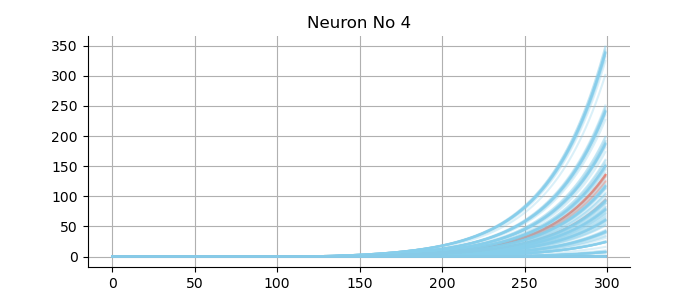

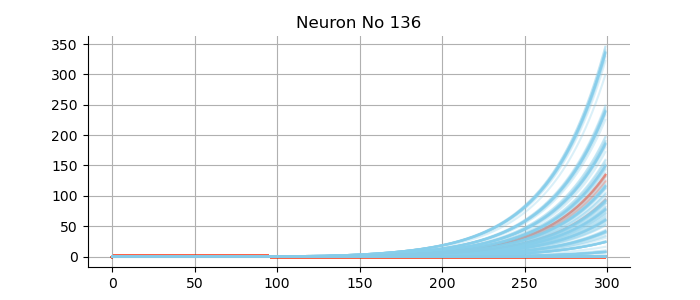

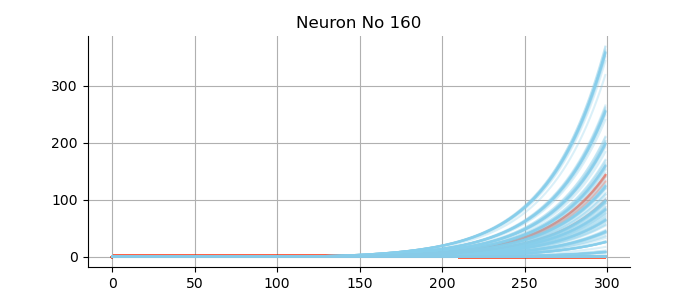

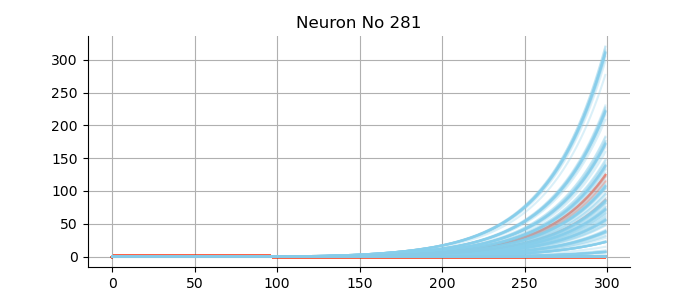

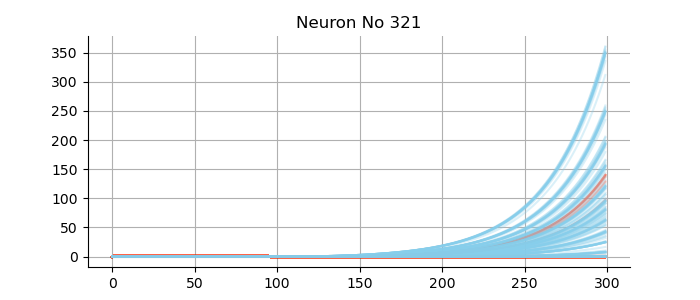

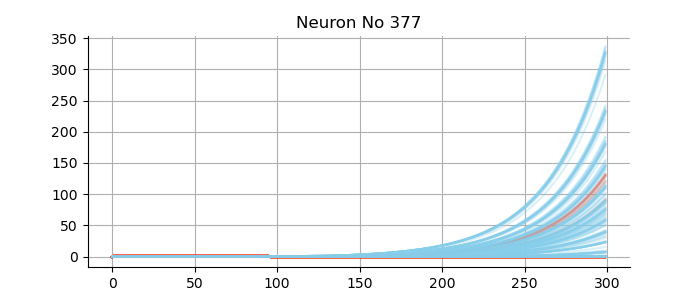

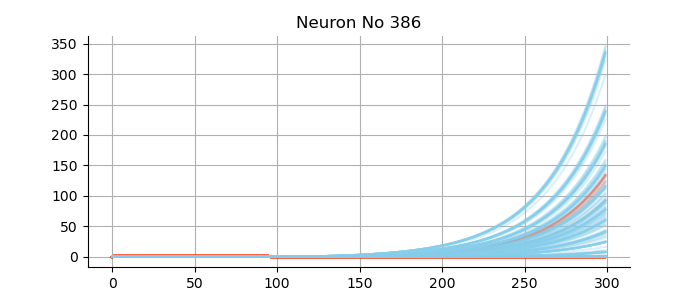

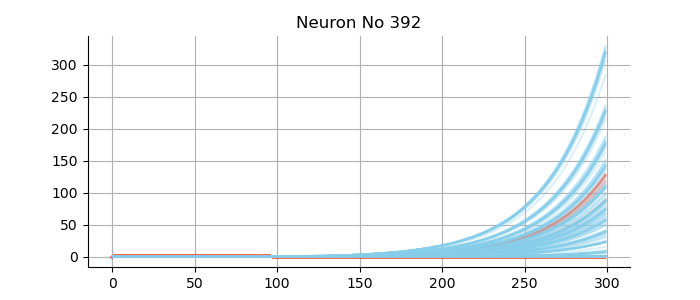

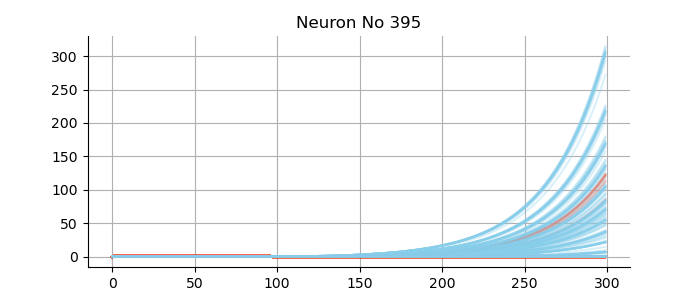

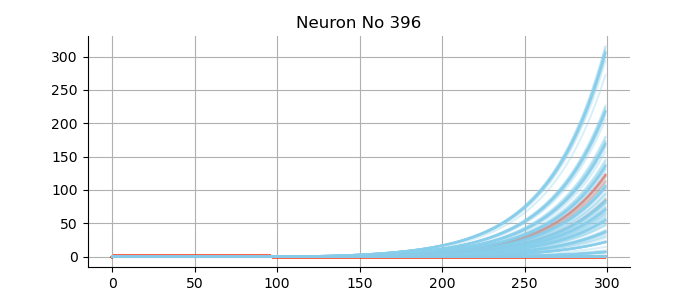

In [29]:
p = data_dict["participations"][-1]

thr = np.quantile(p, 0.98)
for n in range(trajectories.shape[0])[:]:
    part = np.std(trajectories[n, :, :]) + np.mean(trajectories[n, :, :])
    if p[n] > thr:
        fig, ax = plt.subplots(1, 1, figsize = (7, 3))
        for k in range(trajectories.shape[-1]):
            color = 'tomato' if k < trajectories.shape[-1]//2 else 'skyblue'
            ax.plot(trajectories[n, :, k], color = color, alpha = 0.3)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(True)
        ax.set_title(f"Neuron No {n}")
        plt.show()

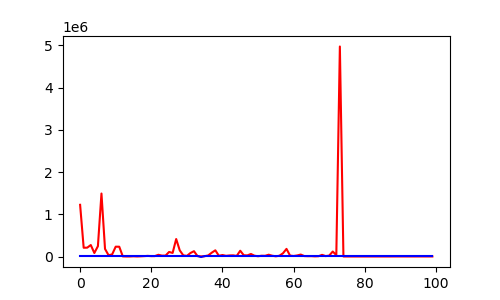

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (5, 3))
ax.plot(data_dict["activity_penalties"], color='r')
ax.plot(data_dict["activity_penalties_dropout"], color='b')
plt.show()

NameError: name 'v' is not defined

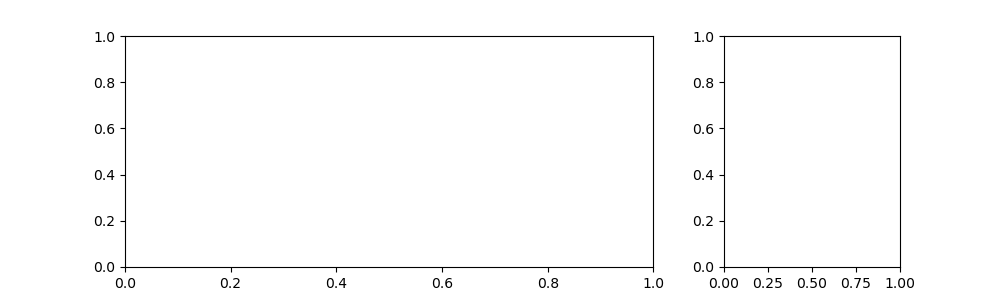

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw = {'width_ratios': [3, 1]})
axes[0].stem(np.arange(len(v)), v, linefmt='-b', markerfmt='ro', basefmt=' ')
axes[0].scatter(x=np.arange(len(v)), y=v, color='r', edgecolors='black', zorder=3)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)


axes[1].hist(v, bins = 50, color='skyblue', edgecolor='k', orientation = 'horizontal')
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
axes[1].set_ylim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].axhline(0.5, linestyle='--', color='k', alpha = 0.5)
axes[1].axhline(0.5, linestyle='--', color='k', alpha = 0.5)
plt.show()

In [ ]:
print(min(v), np.mean(v), max(v), np.std(v))

In [ ]:
print(min(v), np.mean(v), max(v), np.std(v))